# io

In [177]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

In [178]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,9)

In [179]:
import skimage 
raw = skimage.io.imread("../images/raw.jpg")

In [180]:
def show(image,gray=True):
    if gray:
        sns.heatmap(image,cmap='gray',rasterized=True)
#         plt.imshow(image,cmap='gray')
    else:
        plt.imshow(image,rasterized=True)

In [181]:
def show_f(frequency_val,vmin=-500,vmax=500,cmap = 'coolwarm'):
    sns.heatmap(frequency_val.astype(float),cmap=cmap,
                rasterized=True,
                vmin=vmin, vmax=vmax)

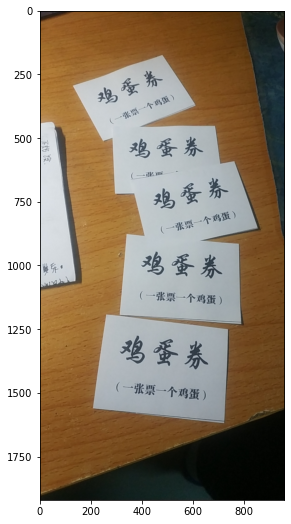

In [182]:
show(raw,gray=False)
plt.savefig("../figures/raw.pdf")

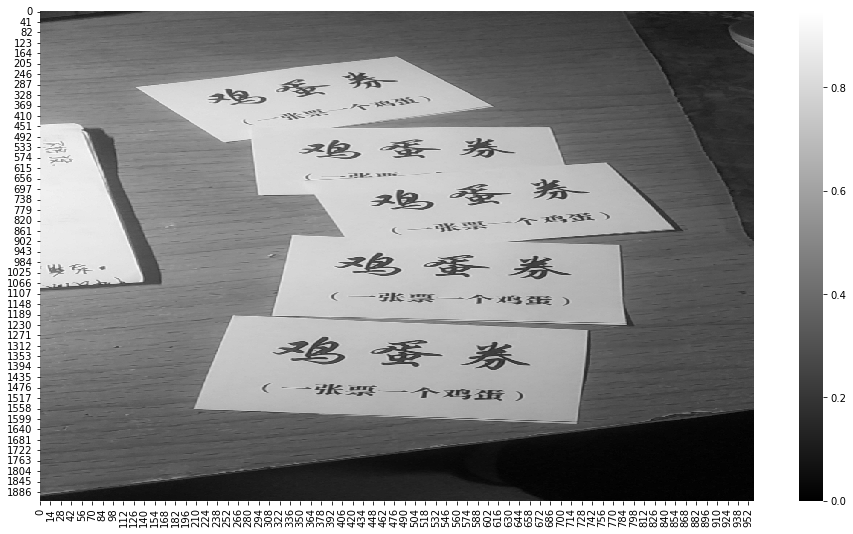

In [183]:
gray = skimage.color.rgb2gray(raw)
show(gray)
plt.savefig("../figures/gray.pdf")

# 灰度图像的频域滤波器

## 灰度图像进行离散傅里叶变换

In [184]:
freq = np.fft.fft2(gray)
freq

array([[ 8.41393240e+05    +0.j        , -1.03230181e+05-68692.72056888j,
         7.03455451e+03-45360.88656474j, ...,
         2.06854644e+04+51935.01100302j,  7.03455451e+03+45360.88656474j,
        -1.03230181e+05+68692.72056888j],
       [-1.73068949e+05-53886.92674449j,  7.38309809e+03-27326.0261311j ,
        -8.35470098e+03 -2059.97132526j, ...,
        -8.28995111e+02-14624.66799169j, -4.95221944e+03-14970.72841223j,
         3.28000276e+04+28119.96520701j],
       [-7.02576344e+04-32146.01773387j,  2.11882182e+04+25719.8482136j ,
         1.89886086e+04 -2343.3920532j , ...,
        -1.59283467e+04+16242.65236811j,  7.69331562e+02+12342.38174474j,
         4.33119379e+04  -643.12718113j],
       ...,
       [-2.64914561e+04+35849.11055497j, -6.91244009e+03+11048.69538871j,
        -8.42552290e+02 +1785.43749532j, ...,
         6.57399744e+03 -1837.6536427j , -3.49566281e+03 -2111.18973683j,
         1.82368600e+04-15175.73478837j],
       [-7.02576344e+04+32146.01773387j,  4.

In [185]:
shifted = np.fft.fftshift(freq)

/home/cbs/anaconda3/lib/python3.9/site-packages/numpy/lib/histograms.py:852: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/home/cbs/anaconda3/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


<AxesSubplot:ylabel='Frequency'>

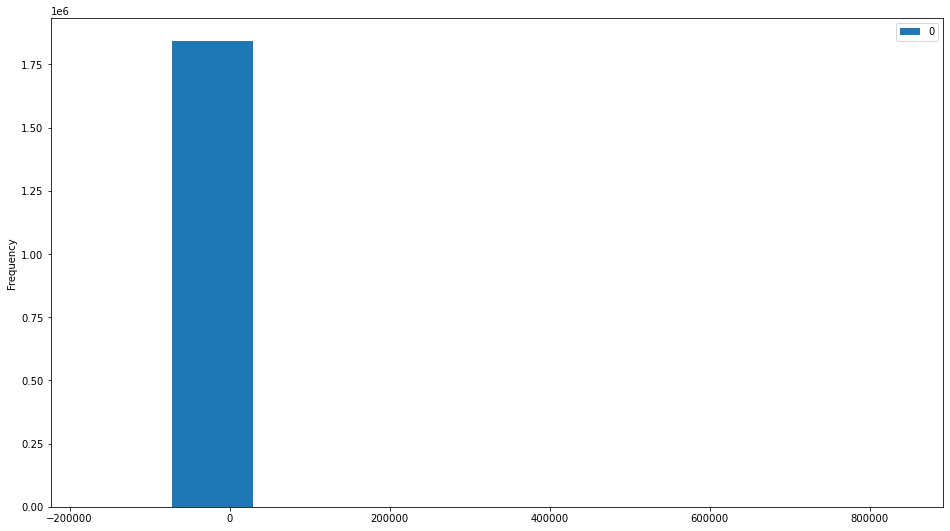

In [186]:
d = pd.DataFrame(shifted.flatten())
d.plot(kind='hist')

/home/cbs/anaconda3/lib/python3.9/site-packages/numpy/lib/histograms.py:852: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/home/cbs/anaconda3/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


(-100000.0, 100000.0)

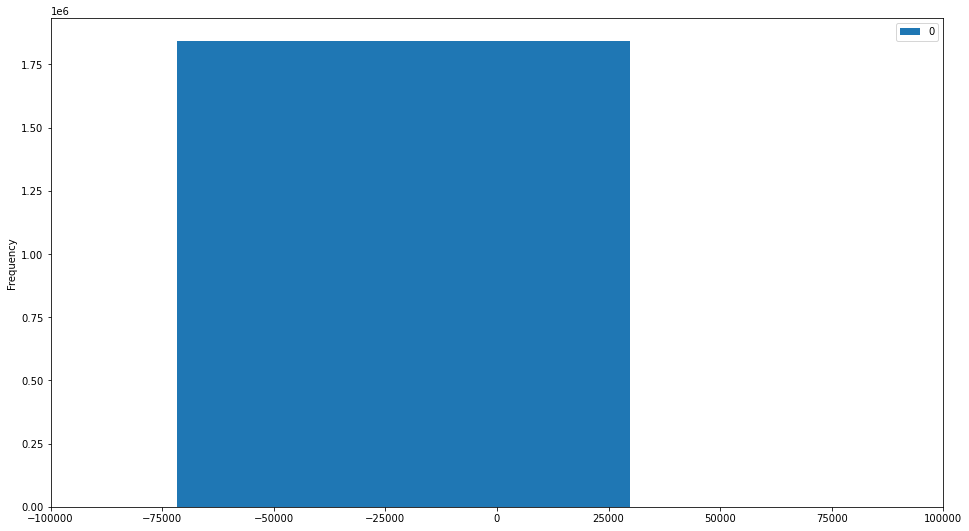

In [187]:
d.plot(kind='hist')
plt.xlim(-100000,100000)

/tmp/ipykernel_5307/566587111.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  real = shifted.copy().astype(float)


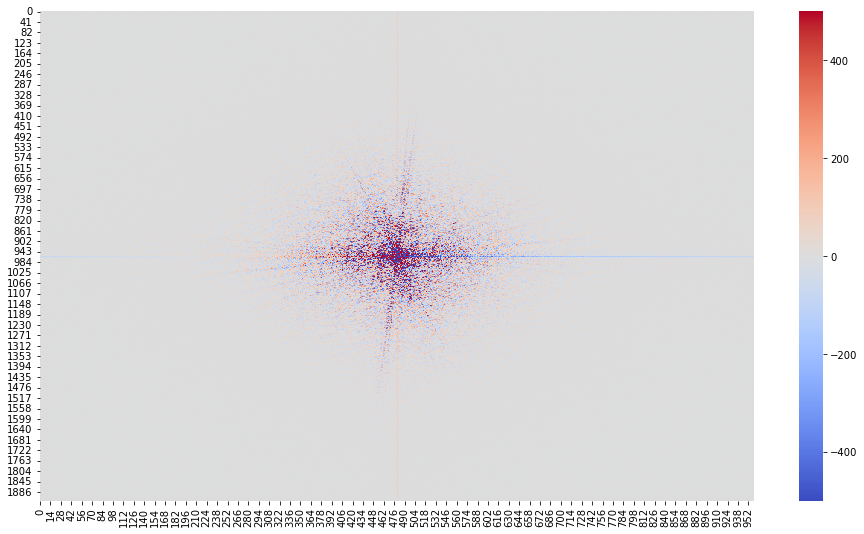

In [188]:
real = shifted.copy().astype(float)
real[real > 500] = 500
real[real < -500] = -500
show_f(real)
plt.savefig("../figures/freq.pdf")

## 梯形低通滤波

$$
H(u,v) = \begin{cases}
1 & D \in (-\infty,D_0) \\
\frac{D(u,v)-D_1}{D_0 - D_1} & D \in (D_0, D_1) \\
0 & D \in (D_1,+\infty)
\end{cases}
$$

$$
D = \sqrt{u^2 + v^2}
$$

$$
\begin{cases}
  D_0 = 10 \\
  D_1 = 80
\end{cases}
$$

### raw mask

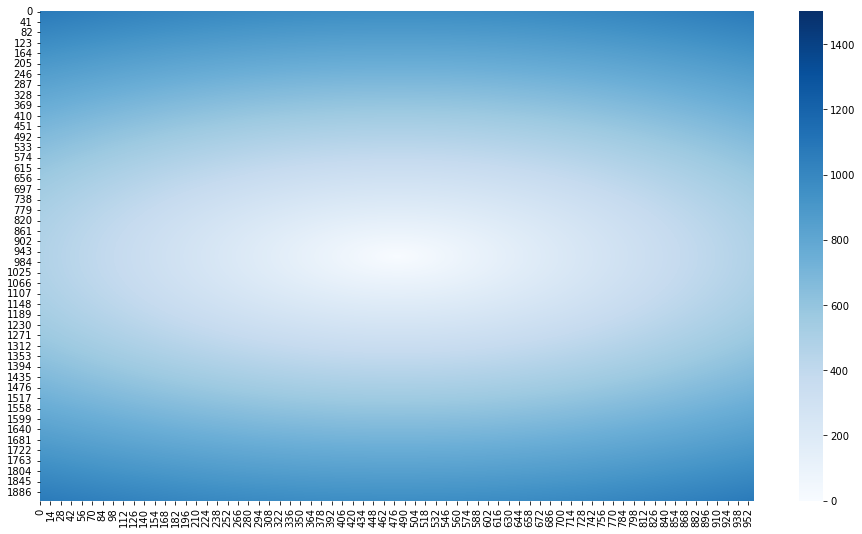

In [189]:
line_size, col_size = shifted.shape
u = abs(np.arange(-col_size//2, col_size//2))
v = abs(np.arange(-line_size//2, line_size//2))
u,v = np.meshgrid(u,v)
raw_mask = (u*u + v*v)**(1/2)
show_f(raw_mask,vmax = 1500, vmin = 0,cmap='Blues')
plt.savefig("../figures/raw_mask.pdf")

引入
$$
D' = \frac{D-D_1}{D_0 - D_1}
$$
则
$$
H = \begin{cases}
  1 & D' \in (1,+\infty) \\
  D' & D' \in (0,1) \\
  0 & D' \in (-\infty,0)
\end{cases}
$$

### case 1

In [190]:
low = 10
high = 80

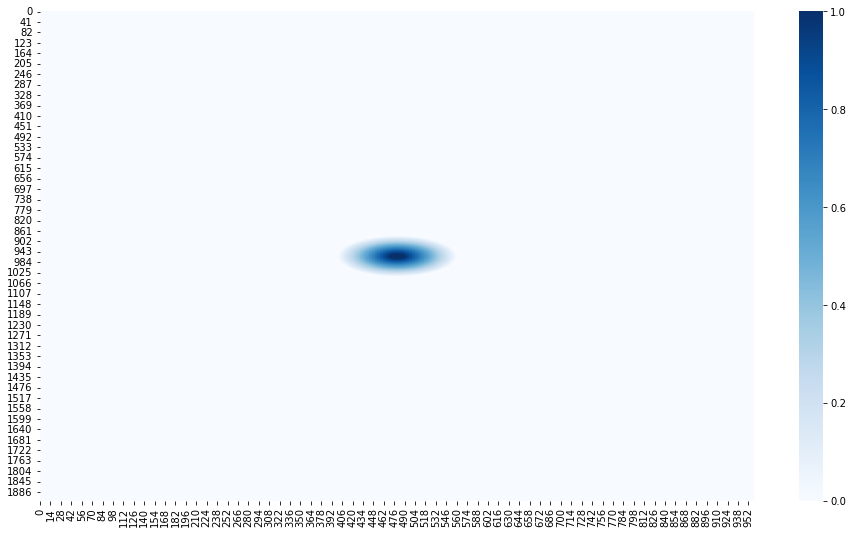

In [191]:
mask = raw_mask.copy()
mask -= high
mask /= (low-high)
mask[mask > 1] = 1
mask[mask < 0] = 0
show_f(mask,vmin=0,vmax=1,cmap='Blues')
plt.savefig("../figures/low_pass_mask.pdf")

/tmp/ipykernel_5307/806846876.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  sns.heatmap(frequency_val.astype(float),cmap=cmap,


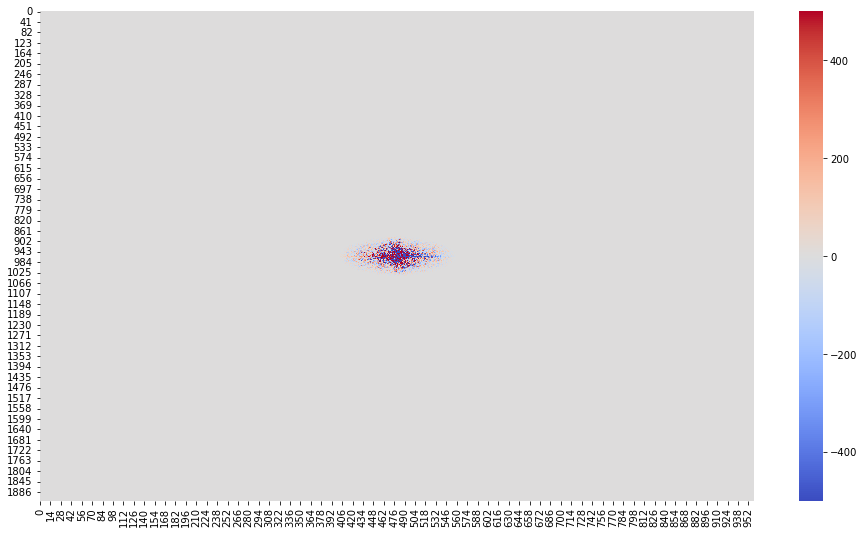

In [192]:
low_pass_freq = shifted * mask
show_f(low_pass_freq)
plt.savefig("../figures/low_pass_freq.pdf")

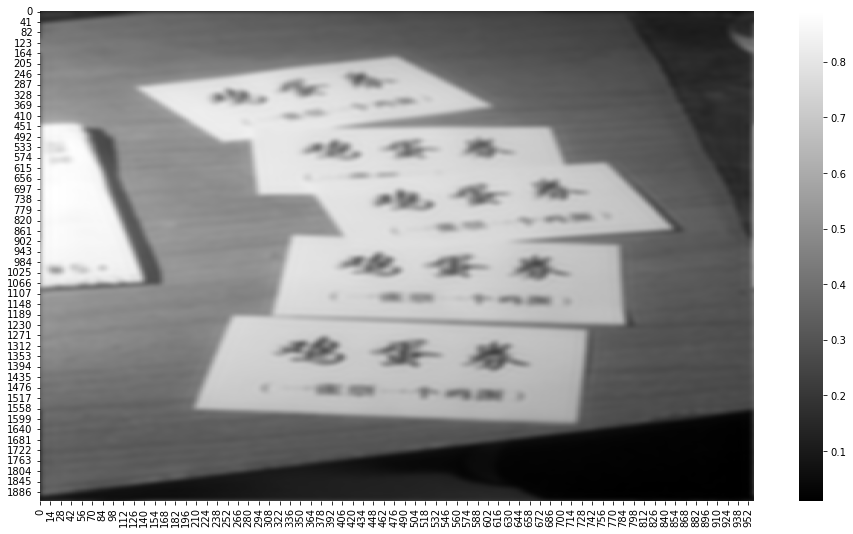

In [193]:
filtered = np.fft.ifftshift(low_pass_freq)
filtered = np.fft.ifft2(filtered)
filtered = abs(filtered)
show(filtered)
plt.savefig("../figures/low_pass_filter.pdf")

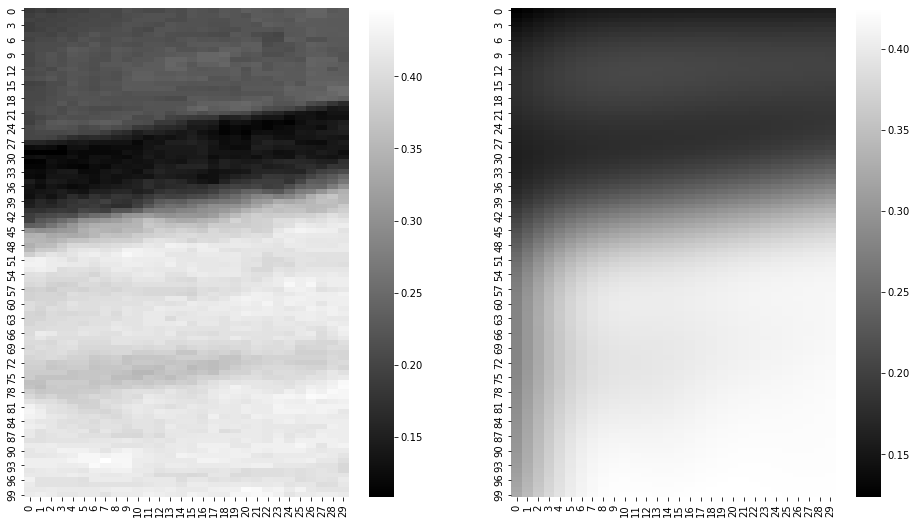

In [194]:
plt.subplot(1,2,1)
show(gray[:100,:30])
plt.subplot(1,2,2)
show(filtered[:100,:30])
plt.savefig("../figures/ringingeffect.pdf")

### case 2

In [195]:
low = 100
high = 300

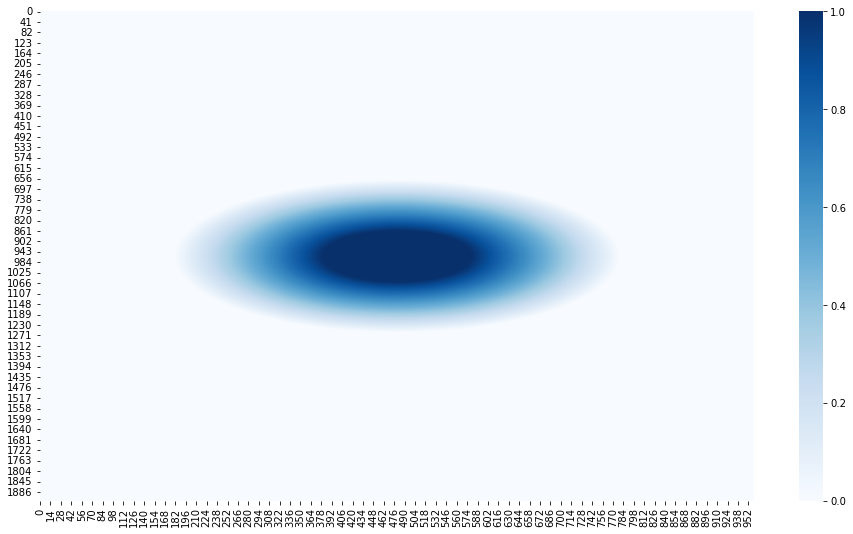

In [196]:
mask = raw_mask.copy()
mask -= high
mask /= (low-high)
mask[mask > 1] = 1
mask[mask < 0] = 0
show_f(mask,vmin=0,vmax=1,cmap='Blues')
plt.savefig("../figures/low_pass_mask_2.pdf")

/tmp/ipykernel_5307/806846876.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  sns.heatmap(frequency_val.astype(float),cmap=cmap,


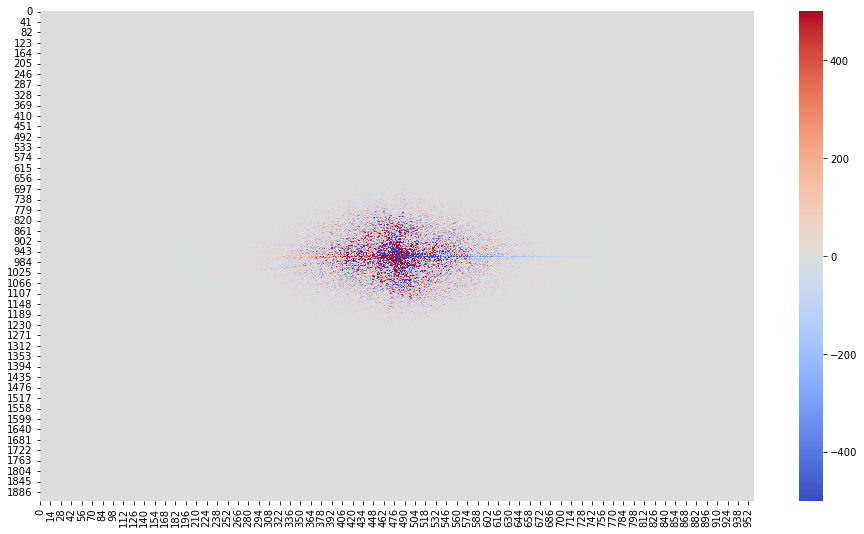

In [197]:
low_pass_freq = shifted * mask
show_f(low_pass_freq)
plt.savefig("../figures/low_pass_freq_2.pdf")

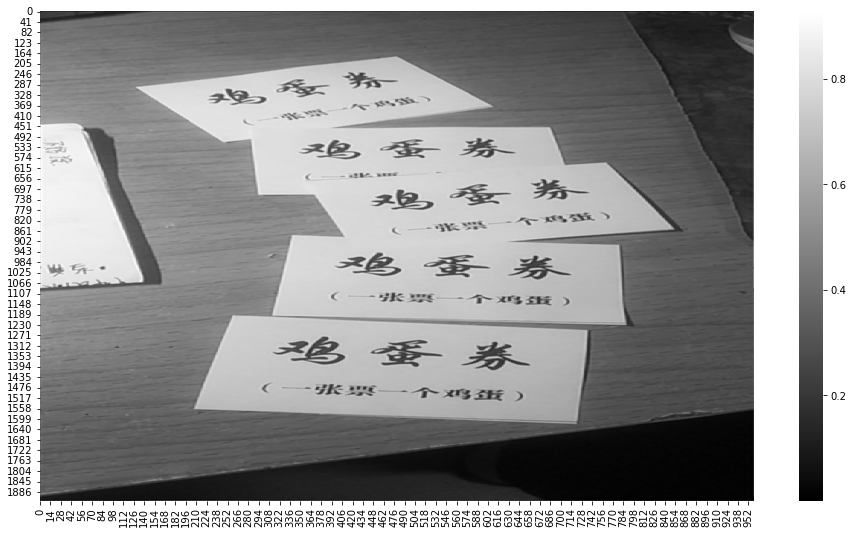

In [198]:
filtered = np.fft.ifftshift(low_pass_freq)
filtered = np.fft.ifft2(filtered)
filtered = abs(filtered)
show(filtered)
plt.savefig("../figures/low_pass_filter_2.pdf")

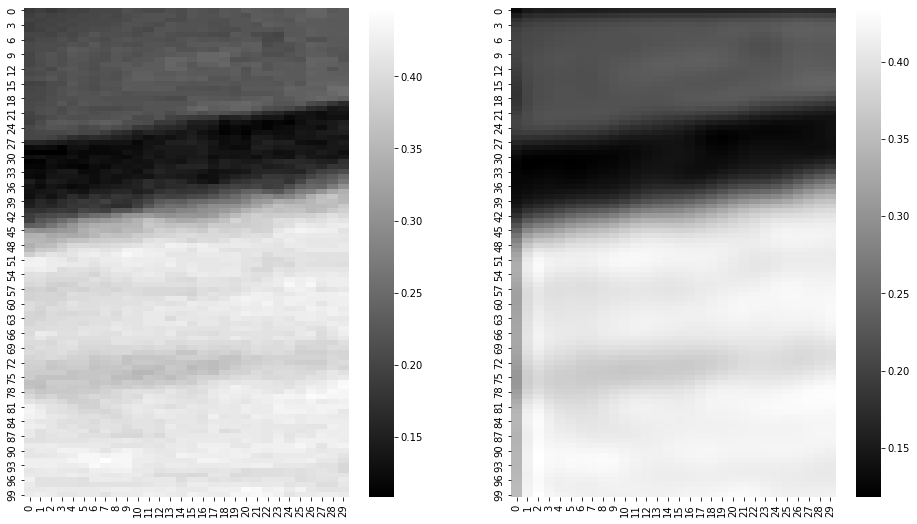

In [199]:
plt.subplot(1,2,1)
show(gray[:100,:30])
plt.subplot(1,2,2)
show(filtered[:100,:30])
plt.savefig("../figures/ringingeffect_2.pdf")

## 梯形高通滤波

$$
H(u,v) = \begin{cases}
0 & D \in (-\infty,D_1) \\
\frac{D(u,v)-D_1}{D_0 - D_1} & D \in (D_1, D_0) \\
1 & D \in (D_0,+\infty)
\end{cases}
$$

引入
$$
D' = \frac{D-D_1}{D_0 - D_1}
$$
则
$$
H = \begin{cases}
  0 & D' \in (-\infty,0) \\
  D' & D' \in (0,1) \\
  1 & D' \in (0,+\infty)
\end{cases}
$$

### case 1

In [200]:
low = 10
high = 80

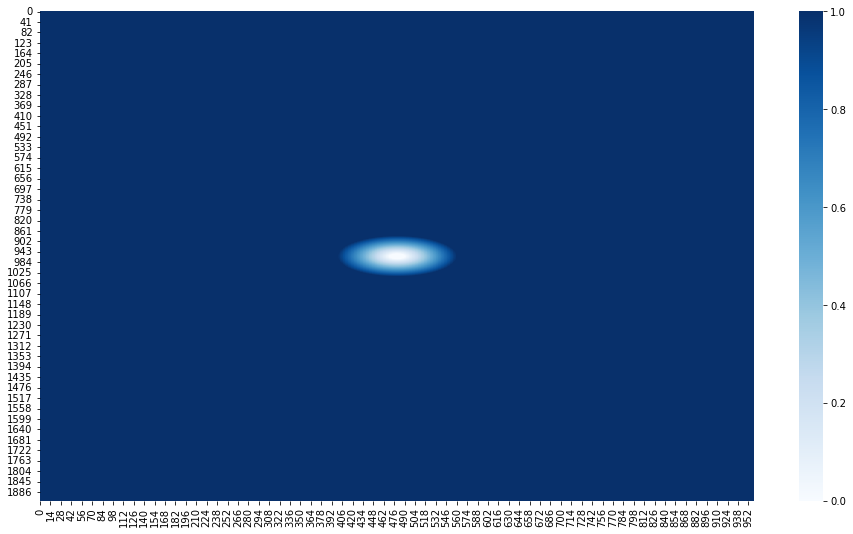

In [201]:
mask = raw_mask.copy()
mask -= low
mask /= (high-low)
mask[mask > 1] = 1
mask[mask < 0] = 0
show_f(mask,vmin=0,vmax=1,cmap='Blues')
plt.savefig("../figures/high_pass_mask_1.pdf")

/tmp/ipykernel_5307/806846876.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  sns.heatmap(frequency_val.astype(float),cmap=cmap,


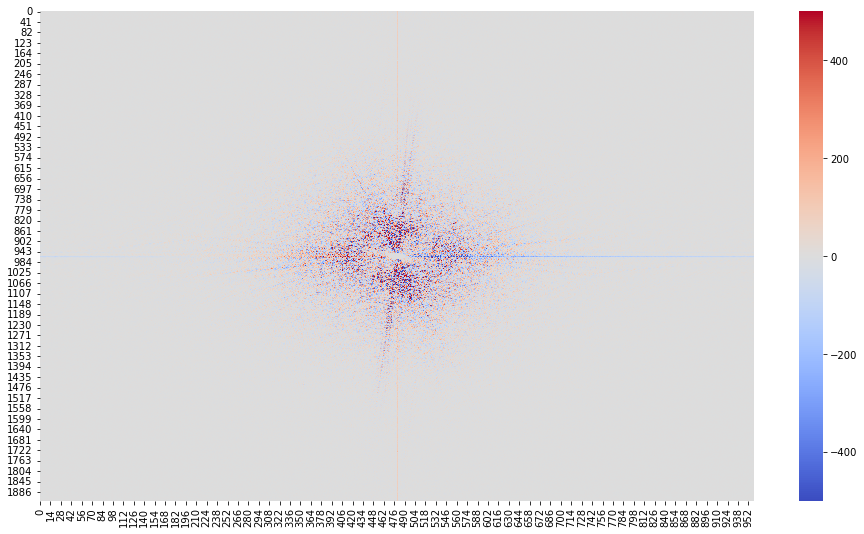

In [202]:
low_pass_freq = shifted * mask
show_f(low_pass_freq)
plt.savefig("../figures/high_pass_freq_1.pdf")

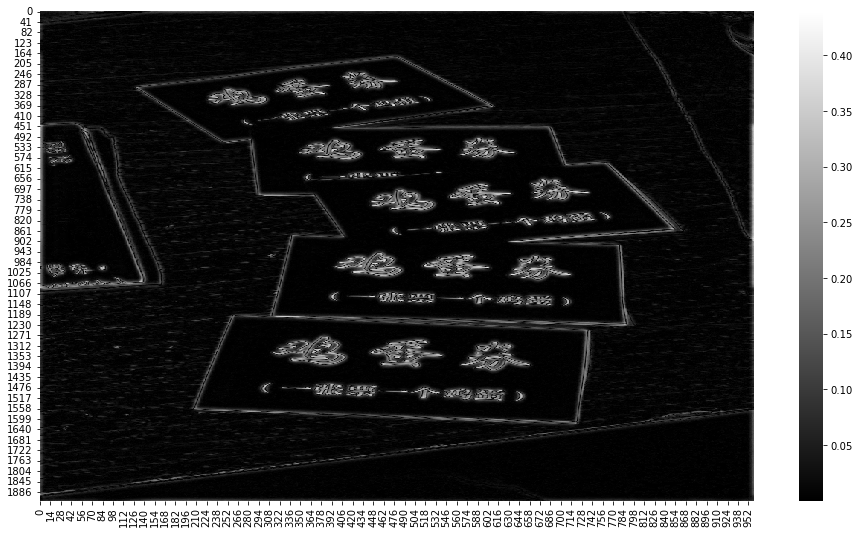

In [203]:
filtered = np.fft.ifftshift(low_pass_freq)
filtered = np.fft.ifft2(filtered)
filtered = abs(filtered)
show(filtered)
plt.savefig("../figures/high_pass_filter_1.pdf")

### case 2

In [204]:
low = 100
high = 300

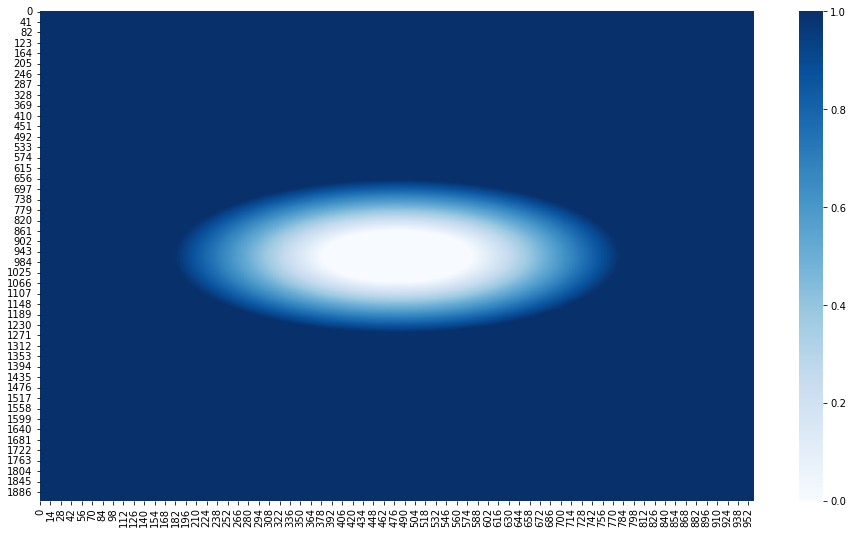

In [205]:
mask = raw_mask.copy()
mask -= low
mask /= (high-low)
mask[mask > 1] = 1
mask[mask < 0] = 0
show_f(mask,vmin=0,vmax=1,cmap='Blues')
plt.savefig("../figures/high_pass_mask_2.pdf")

/tmp/ipykernel_5307/806846876.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  sns.heatmap(frequency_val.astype(float),cmap=cmap,


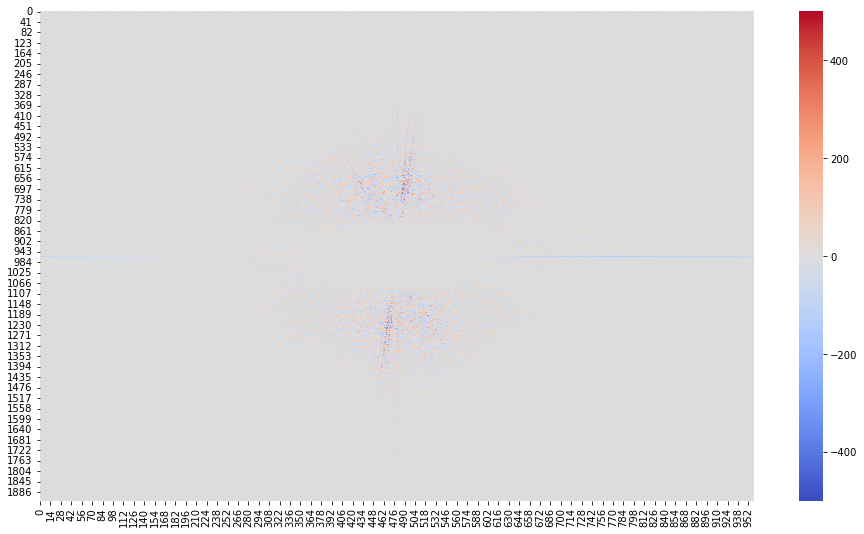

In [206]:
low_pass_freq = shifted * mask
show_f(low_pass_freq)
plt.savefig("../figures/high_pass_freq_2.pdf")

/tmp/ipykernel_5307/806846876.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  sns.heatmap(frequency_val.astype(float),cmap=cmap,


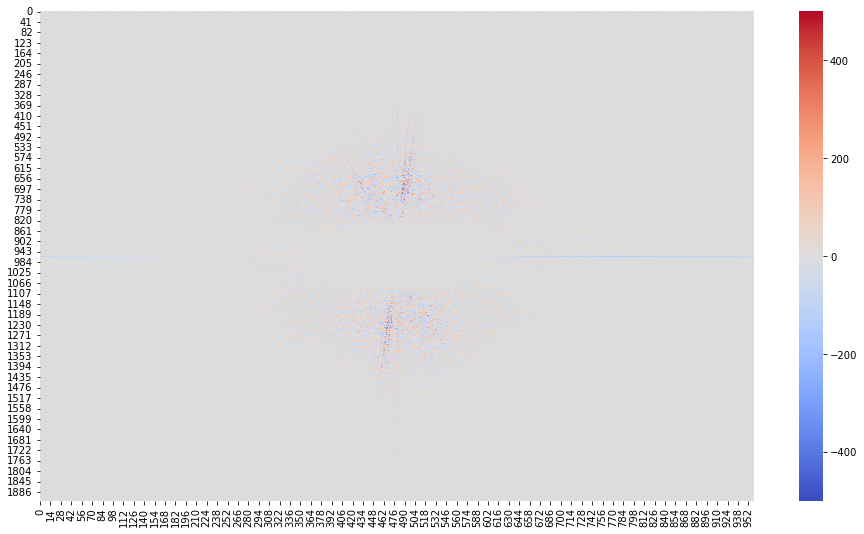

In [207]:
low_pass_freq = shifted * mask
show_f(low_pass_freq)
plt.savefig("../figures/high_pass_freq_2.pdf")

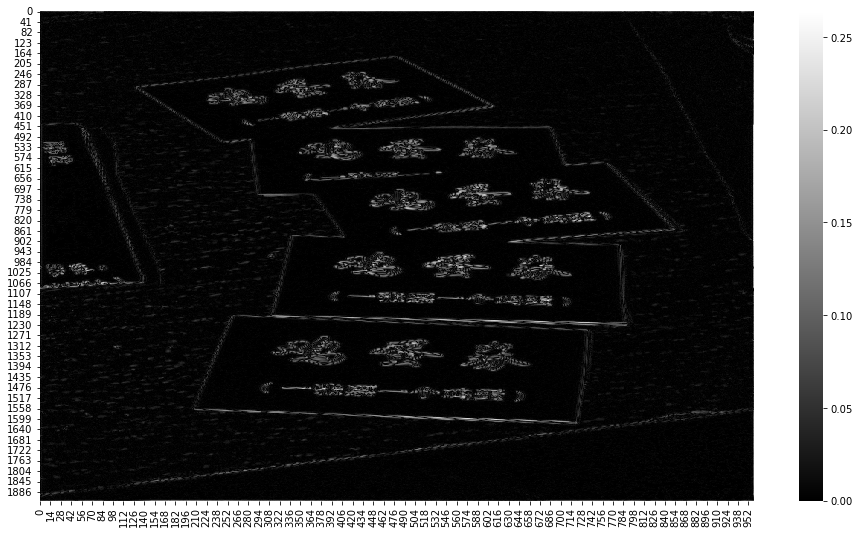

In [208]:
filtered = np.fft.ifftshift(low_pass_freq)
filtered = np.fft.ifft2(filtered)
filtered = abs(filtered)
show(filtered)
plt.savefig("../figures/high_pass_filter_2.pdf")

# 灰度图像的离散余弦变换

## case 1

In [238]:
cell = 8
freq = gray.copy()
outcome = gray.copy()

-   [scipy.fft.dctn](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.dctn.html)
-   [scipy.fft.dct](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.dct.html)

In [239]:
import itertools
for i,j in itertools.product(
        range(cell, line_size, cell), 
        range(cell, col_size,cell)):
    freq[i-cell:i, j-cell:j] = scipy.fft.dctn(gray[i-cell:i, j-cell:j])
    outcome[i-cell:i, j-cell:j] = scipy.fft.idctn(freq[i-cell:i, j-cell:j])

<AxesSubplot:ylabel='Frequency'>

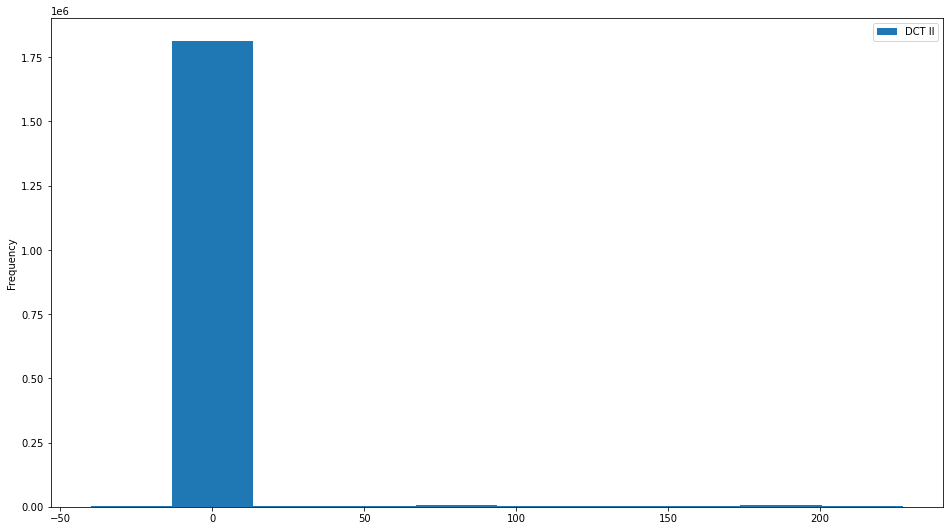

In [240]:
pd.DataFrame({'DCT II':freq.flatten()}).plot(kind='hist')

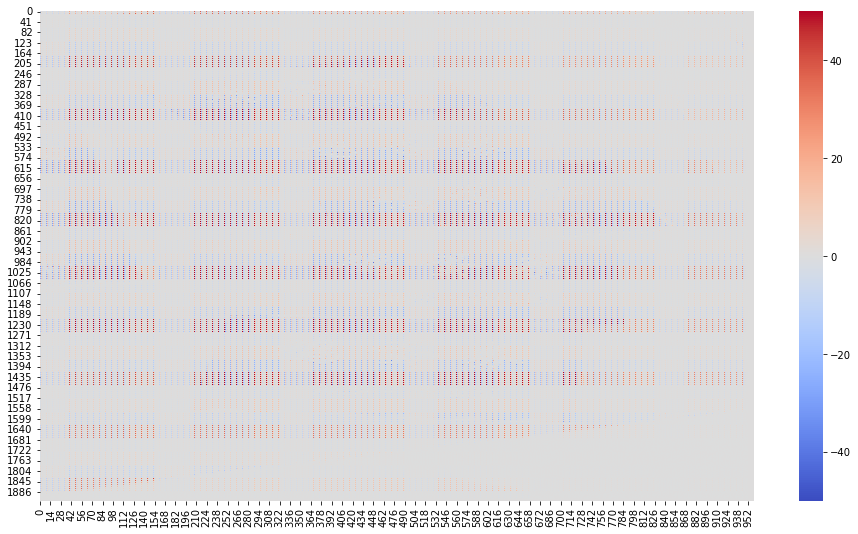

In [256]:
show_f(freq,vmax=50,vmin=-50)
plt.savefig("../figures/dct_II_freq.pdf")

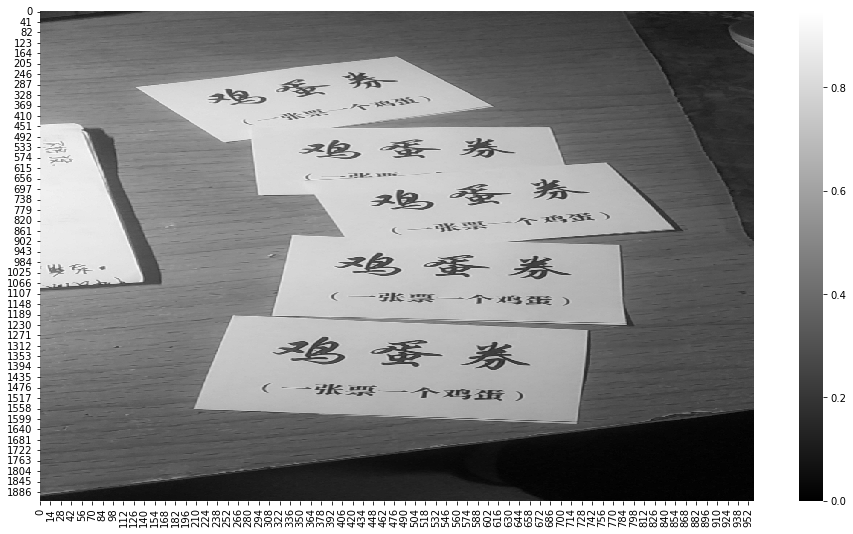

In [242]:
show(outcome)

In [243]:
dct_stat = pd.DataFrame({'diff':gray.flatten()-outcome.flatten()})
dct_stat.describe()

diff
count  1.843200e+06
mean  -1.210229e-18
std    8.096339e-17
min   -5.551115e-16
25%   -5.551115e-17
50%    0.000000e+00
75%    5.551115e-17
max    4.440892e-16

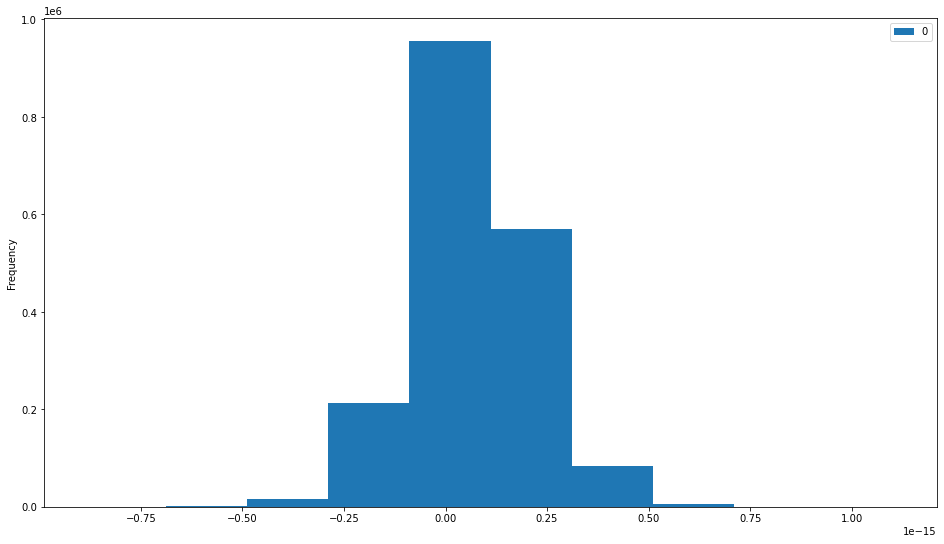

In [267]:
dct_stat.plot(kind='hist')
plt.savefig("../figures/dct_III_diff_hist.pdf")

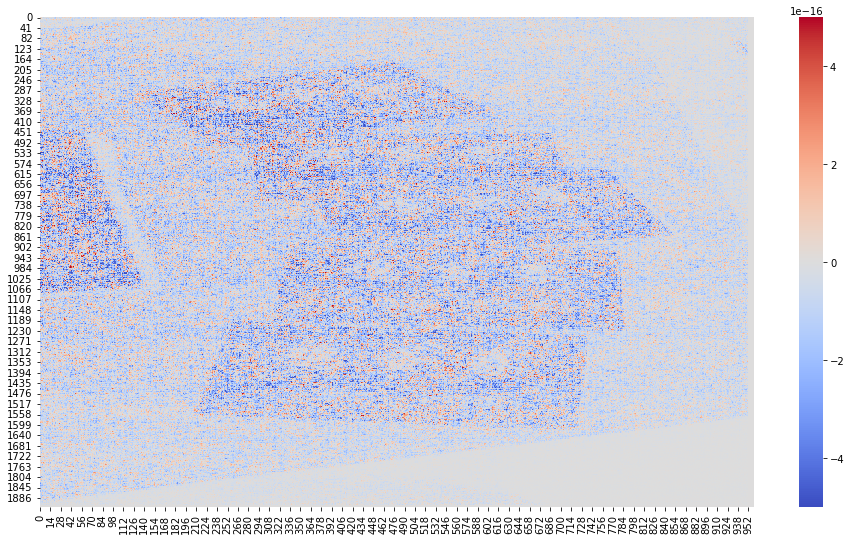

In [257]:
show_f(outcome - gray,vmin = -5e-16, vmax=5e-16)
plt.savefig("../figures/dct_II_diff.pdf")

## case 2

In [258]:
for i,j in itertools.product(
        range(cell, line_size, cell), 
        range(cell, col_size,cell)):
    freq[i-cell:i, j-cell:j] = scipy.fft.dctn(
        gray[i-cell:i, j-cell:j],
        type=3
    )
    outcome[i-cell:i, j-cell:j] = scipy.fft.idctn(freq[i-cell:i, j-cell:j],type=3)

<AxesSubplot:ylabel='Frequency'>

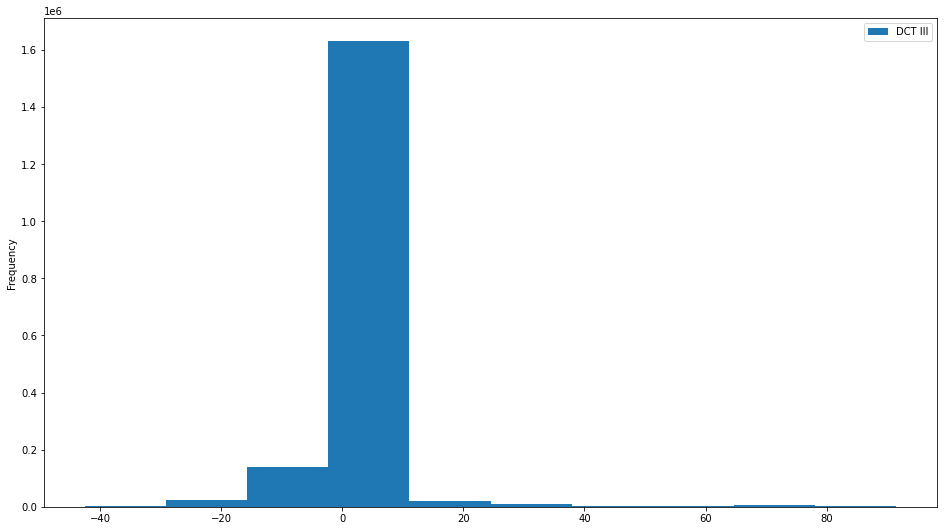

In [259]:
pd.DataFrame({'DCT III':freq.flatten()}).plot(kind='hist')

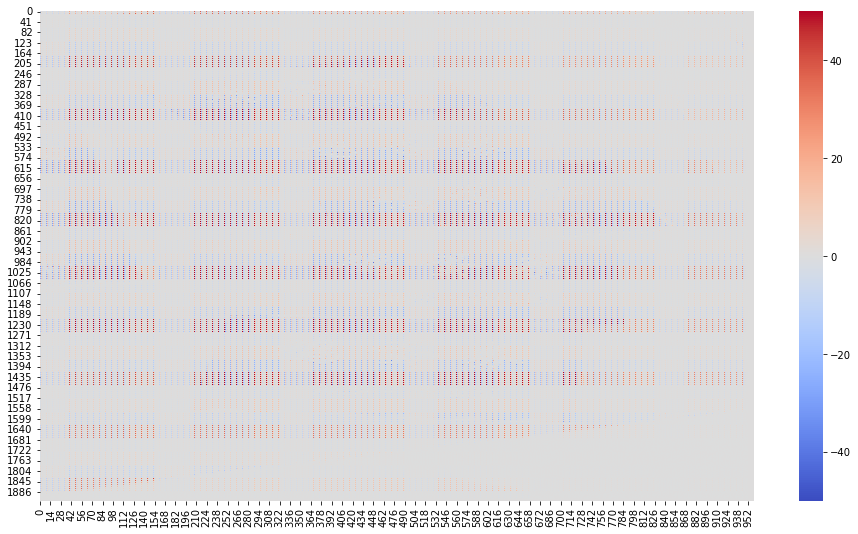

In [260]:
show_f(freq,vmax=50,vmin=-50)
plt.savefig("../figures/dct_III_freq.pdf")

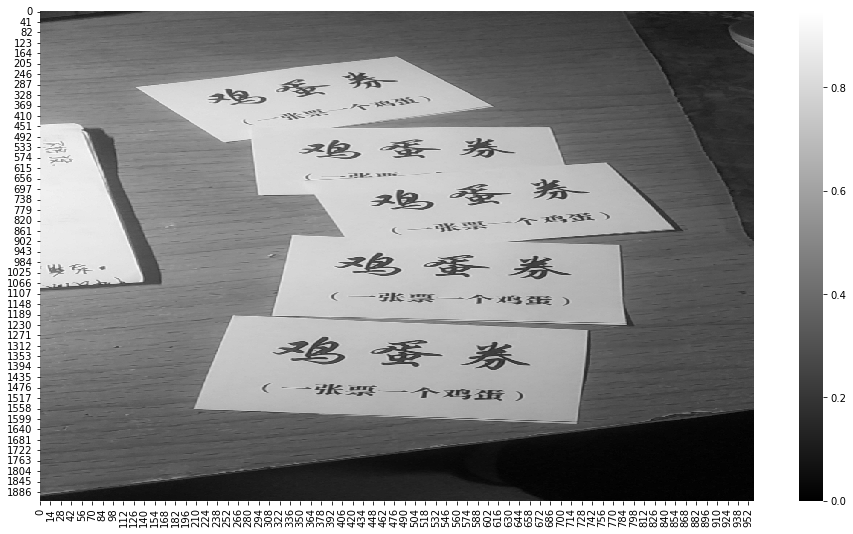

In [261]:
show(outcome)

In [262]:
dct_stat = pd.DataFrame(gray.flatten()-outcome.flatten())
dct_stat.describe()

0
count  1.843200e+06
mean   4.930320e-17
std    1.296808e-16
min   -8.881784e-16
25%    0.000000e+00
50%    2.775558e-17
75%    1.110223e-16
max    1.110223e-15

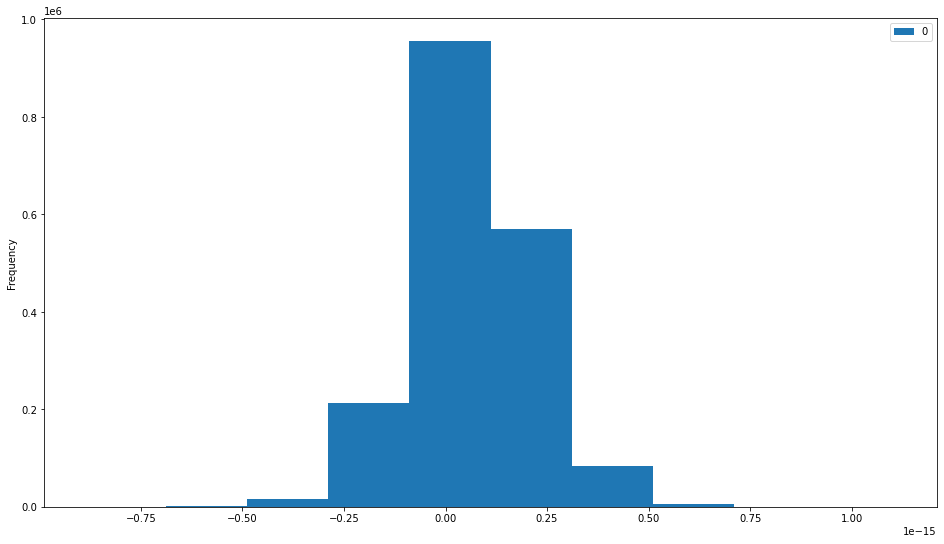

In [263]:
dct_stat.plot(kind='hist')
plt.savefig("../figures/dct_III_hist.pdf")

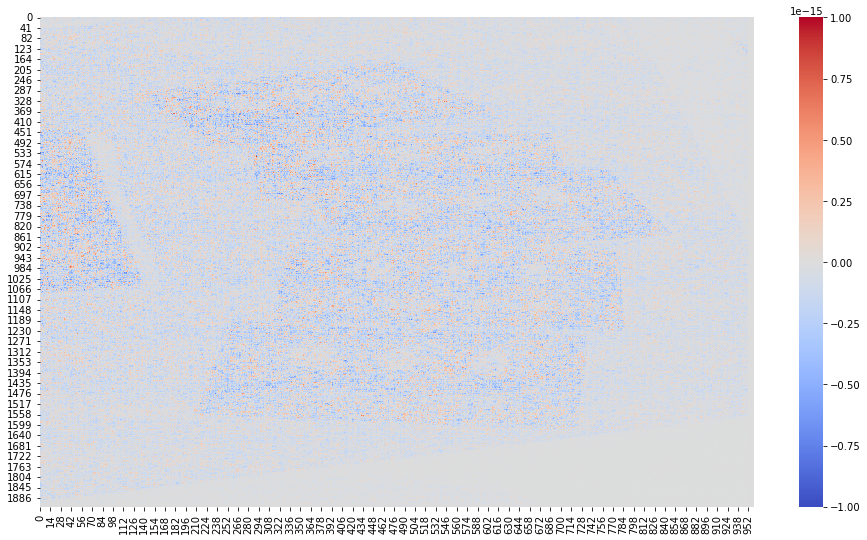

In [265]:
show_f(outcome - gray,vmin = -1e-15, vmax=1e-15)
plt.savefig("../figures/dct_III_diff.pdf")